# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [57]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1", na_values= "-999").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

# Drop columns that have greater than 40% NA
dat = dat.loc[:, dat.isnull().sum() <= (0.4*len(dat))]

print(f"Final DataFrame shape: {dat.shape} ")


Final DataFrame shape: (214, 17) 


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [58]:
# Check NAs in the data frame
dat.isna().sum()

AdultBodyMass          3
Diet_Invertebrates    15
Diet_Vertebrates      15
Diet_Fruits           15
Diet_Flowers          15
Diet_Seeds            15
Diet_Plants           15
Diet_Other            15
HabitatBreadth        26
ActivityCycle         22
ForagingStratum       24
LitterSize            83
Dry                    0
Humid                  0
Montane                0
Subarid                0
Subhumid               0
dtype: int64

In [59]:
# Separate numeric and categorical columns
numeric_cols = dat.select_dtypes(include=['number']).columns
categorical_cols = dat.select_dtypes(include=['object']).columns

# Create imputers for numeric and categorical columns
numeric_imputer = KNNImputer(n_neighbors = 5)

# Impute missing values for numeric
dat[numeric_cols] = pd.DataFrame(numeric_imputer.fit_transform(dat[numeric_cols]))

# Apply mode imputation for categorical features
dat[categorical_cols] = dat[categorical_cols].fillna(dat[categorical_cols].mode().iloc[0])

# Check to ensure no more NA values
print(f"NAs after imputing:\n\n{dat.isna().sum()}")

NAs after imputing:

AdultBodyMass         0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
dtype: int64


### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [60]:
# Select climate features
target_features = ['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']

# Create new climate column
dat['nClimates'] = dat[target_features].sum(axis=1)
dat = dat.drop(target_features, axis=1)

# Loop through cat columns and encode numerically 
for col in categorical_cols:
    label_encoder = LabelEncoder()
    dat[col] = label_encoder.fit_transform(dat[col])

dat.head()

,AdultBodyMass,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,nClimates
0,78.0,1,0,1,1,0,1,0,1.0,2.0,3.0,1.000,3.0
1,1082.0,0,0,1,0,0,1,0,1.0,1.0,3.0,1.402,2.0
2,946.0,0,0,1,0,0,1,0,2.0,1.0,3.0,4.692,1.0
3,1180.0,0,0,1,0,0,1,0,2.0,1.0,3.0,1.010,4.0
4,1212.5,0,0,1,0,0,1,0,1.0,1.0,3.0,1.540,3.0


In [61]:
# Define features
X = dat.drop('nClimates', axis=1)
y = dat['nClimates']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=808)


### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

In [62]:
# Initialize regressor
dt = DecisionTreeRegressor(
    max_depth=5, 
    random_state=808
)

# Fit model and make predictions
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

Decision Tree MSE: 2.0602


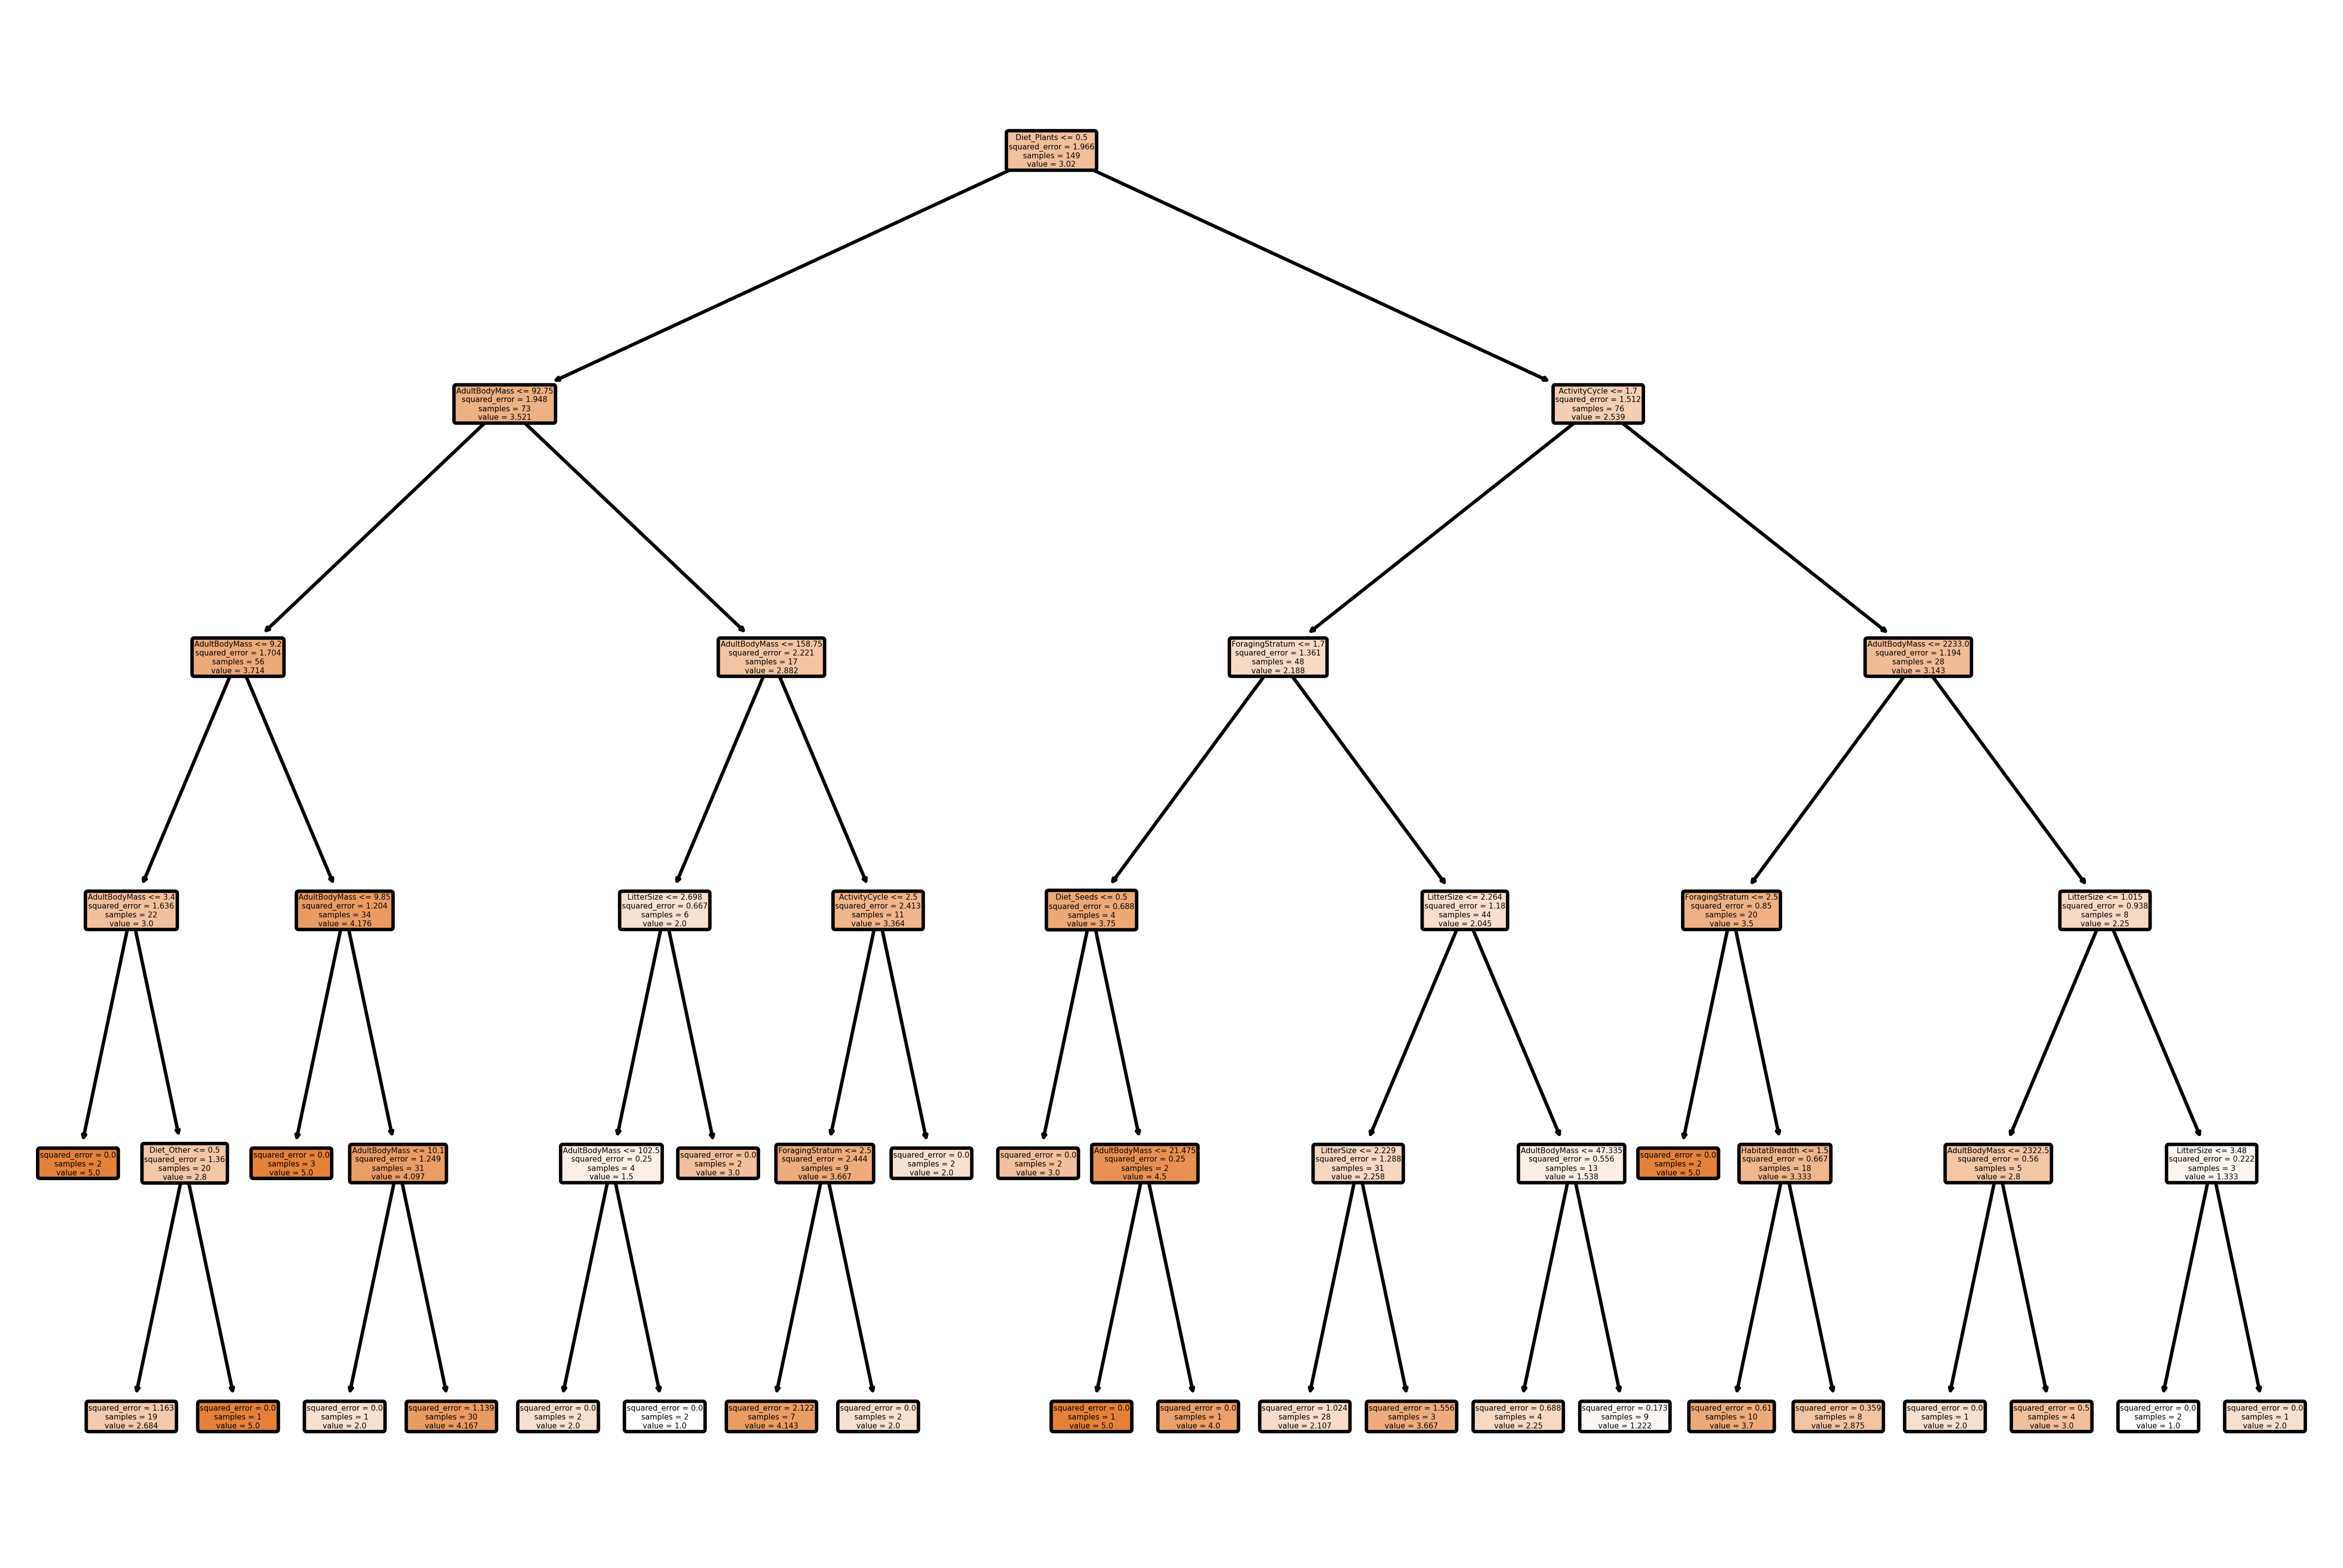

In [63]:
# Plot decision tree
plt.figure(figsize=(12,8), dpi=500)
plot_tree(dt, feature_names=X.columns, class_names=y, filled=True, rounded=True)
print(f"Decision Tree MSE: {mean_squared_error(dt_pred, y_test):.4f}")
plt.show()

Based on the way this tree looks, what would you guess the most important variable to be?

I think the most important variable would be 'Diet Plants' because it's the first feature the tree splits on and the split that reduces the tree's impurity.

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [64]:
# Specify the parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5, 6, 7],
    "max_features": ["sqrt", 6, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize a random forest regressor model
rf = RandomForestRegressor(random_state=808)

# Search for the best parameters for our RF 
gs = GridSearchCV(rf, param_grid=param_grid, 
                    n_jobs=-1, 
                    return_train_score=True, 
                    cv=5, 
                    scoring='neg_mean_squared_error')

# Fit the model with the best parameters
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=808), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 6, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [71]:
# View the best parameters
gs.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [72]:
# Train the best estimator
best_rf = RandomForestRegressor(**gs.best_params_, random_state = 808)

# Fit new rf and generate predictions
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=808)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [73]:
# Generate best estimator predictions
best_preds = best_rf.predict(X_test)

In [74]:
# Print parameters and MSE
print(f"Best parameters: {gs.best_params_}")
print(f"Best Parameters MSE: {mean_squared_error(best_preds, y_test):.4f}")

Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Parameters MSE: 1.4363


In [75]:
# Get feature importance
feature_importance =best_rf.feature_importances_

# Create a df of importance and features
imp_df = pd.DataFrame(zip(X_test.columns, feature_importance), columns=['Feature', 'Importance'])

# Sort by importance
imp_df = imp_df.sort_values(by='Importance', ascending=False)

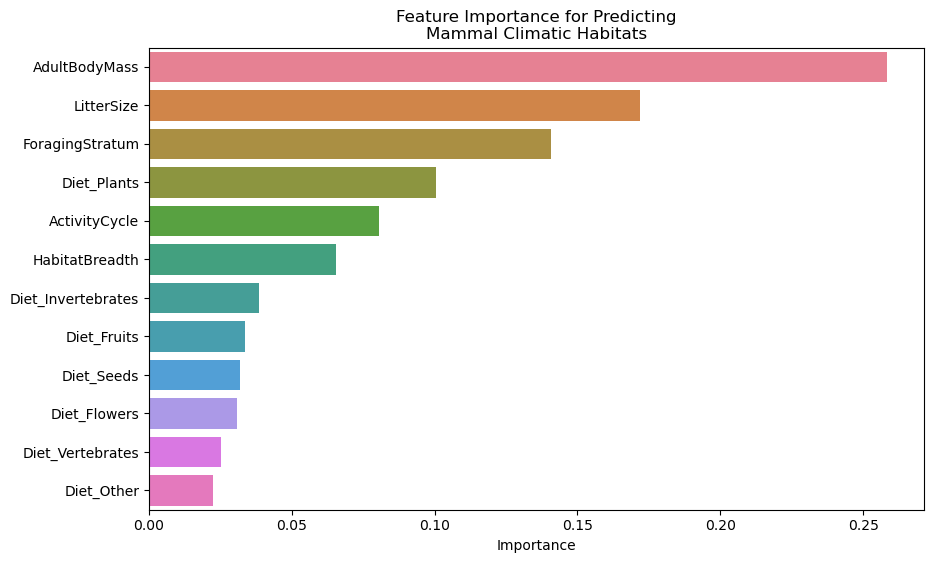

In [77]:
# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=imp_df, hue='Feature', legend=False)

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('')
plt.title('Feature Importance for Predicting\nMammal Climatic Habitats')
plt.show()

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

In [81]:
print(f"Single Tree MSE: {mean_squared_error(dt_pred, y_test)}")
print(f"Ensemble MSE: {mean_squared_error(best_preds, y_test)}")

Single Tree MSE: 2.0601525141415333
Ensemble MSE: 1.4362558706826414


The ensemble model had better accuracy which can be seen due to its lower MSE. The top three most important traits that can influence species' climate adaptability are 'adult body mass', 'litter size', and 'foraging stratum'. 